# Cross-Entropy Method

---

In this notebook, we will train a Cross-Entropy Method with OpenAI Gym's MountainCarContinuous environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import math
import numpy as np
from collections import deque
import os
import matplotlib.pyplot as plt
%matplotlib inline

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU option
USE_GPU = 1
os.environ['CUDA_VISIBLE_DEVICES'] = "0" if USE_GPU else "-1"

import tensorflow as tf

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 2. Instantiate the Environment and Agent

In [2]:
env = gym.make('MountainCarContinuous-v0')
s_num = 1015
env.seed(s_num)
np.random.seed(s_num)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

class Agent():
    def __init__(self, env, h_size=16):
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        tf.reset_default_graph()
        self.sess = tf.Session()
        self._build_model()
        self.sess.run(tf.global_variables_initializer())
        
    def _build_model(self):
        self.weight_list = []
        self.inputs = tf.placeholder(shape=(None, self.s_size), dtype=tf.float32, name = 'input')
        x = tf.layers.dense(inputs=self.inputs, units=self.h_size, activation=tf.nn.relu, name = 'hidden1')
        self.weight_list.append(tf.get_default_graph().get_tensor_by_name(os.path.split(x.name)[0] + '/kernel:0'))
        self.weight_list.append(tf.get_default_graph().get_tensor_by_name(os.path.split(x.name)[0] + '/bias:0'))
        
        self.action_out = tf.layers.dense(x, units=self.a_size, activation=tf.nn.tanh, name = 'output')
        self.weight_list.append(tf.get_default_graph().get_tensor_by_name(os.path.split(self.action_out.name)[0] + '/kernel:0'))
        self.weight_list.append(tf.get_default_graph().get_tensor_by_name(os.path.split(self.action_out.name)[0] + '/bias:0'))
        
    def set_weights(self, weights):
        self.sess.run([tf.assign(i, j) for i,j in zip(self.weight_list, weights)])
    
    def get_weights_dim(self):
        return [i.shape.as_list() for i in self.weight_list]
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = state.ravel()
            action = self.sess.run([self.action_out], feed_dict = {self.inputs:state[np.newaxis,:]})
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(env)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation space: Box(2,)
action space: Box(1,)
  - low: [-1.]
  - high: [1.]


### 3. Train the Agent with a Cross-Entropy Method

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

Episode 10	Average Score: -5.70
Episode 20	Average Score: 0.71
Episode 30	Average Score: 27.95
Episode 40	Average Score: 44.37
Episode 50	Average Score: 54.58
Episode 60	Average Score: 60.85
Episode 70	Average Score: 65.36
Episode 80	Average Score: 68.85
Episode 90	Average Score: 71.57
Episode 100	Average Score: 73.83
Episode 110	Average Score: 83.74

Environment solved in 17 iterations!	Average Score: 91.28


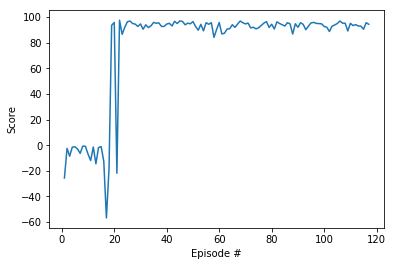

In [3]:
def get_random_weights(agent, sigma):
    return [sigma * np.random.randn(*i) for i in agent.get_weights_dim()]

def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of a cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = get_random_weights(agent, sigma)

    for i_iteration in range(1, n_iterations+1):
        # Generate k (k = population_size) random weights and add it current network's weight
        weights_pop = weights_pop = [[j+k for j,k in zip(best_weight,get_random_weights(agent, sigma)) ] for i in range(pop_size)]
        # Compute rewards based on these simulated weights
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])
        
        # sort rewards, get index of first n rewards of good one
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        # take of the average of these good weights
        best_weight = np.array(elite_weights).mean(axis=0)
        
        # Compute reward (also update this averaging weights to the network)
        reward = agent.evaluate(best_weight, gamma=1.0)
        
        # record it
        scores_deque.append(reward)
        scores.append(reward)
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

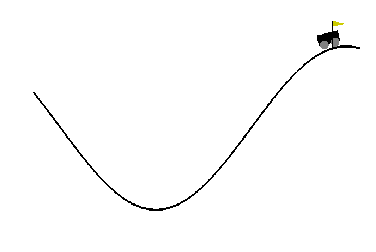

In [12]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
while True:
    action = agent.sess.run([agent.action_out], feed_dict = {agent.inputs:state.ravel()[np.newaxis,:]})
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()